# Composition of GP

## Init

In [1]:
import shutil
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import gpytorch
import jax
import jax.random as jr
import jax.numpy as jnp
import gpjax as gpx
import os
import pandas as pd
# from movement_primitives.data import generate_1d_trajectory_distribution
from PFCS.scripts.gt_plot import read_data

In [2]:
# %matplotlib ipympl

In [3]:
def clean_legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles, strict=False))
    ax.legend(by_label.values(), by_label.keys())
    return ax

In [4]:
USETEX = bool(shutil.which("latex"))
mpl.rcParams["text.usetex"] = USETEX
if USETEX:
    mpl.rcParams["font.family"] = ["serif"]
    # mpl.rcParams["pgf.texsystem"] = "pdflatex"
    # mpl.rcParams["pgf.preamble"] = "\n".join([
    #      # r"\usepackage[utf8x]{inputenc}",
    #      # r"\usepackage[T1]{fontenc}",
    #      r"\usepackage[default]{gfsbodoni}",
    # ])
else:
    mpl.rcParams["font.family"] = ["sans-serif"]
    mpl.rcParams["font.sans-serif"] = [
        "Fira Sans",
        "Computer Modern Sans Serif",
        "DejaVu Sans",
        "Verdana",
        "Arial",
        "Helvetica",
    ]

In [5]:
jax.config.update("jax_enable_x64", True)

# GPJax

## Dataset

In [6]:
n = 100
noise = 0.3
key = jr.key(123)
key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise
D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

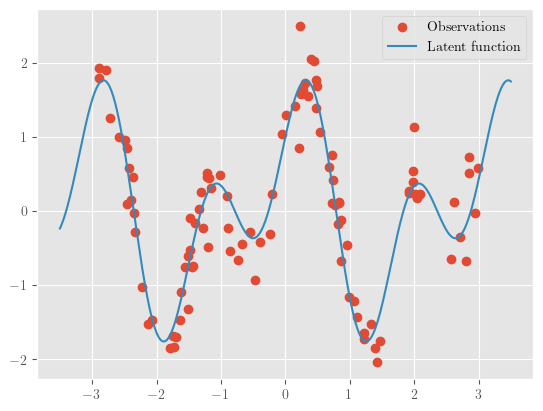

In [7]:
with mpl.style.context("ggplot"):
    cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
    fig, ax = plt.subplots()
    ax.plot(x, y, "o", label="Observations", color=cols[0])
    ax.plot(xtest, ytest, label="Latent function", color=cols[1])
    ax.legend(loc="best")
    plt.show()

## Defining the prior

In [8]:
kernel = gpx.kernels.RBF()  # 1-dimensional input
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

In [9]:
prior_dist = prior.predict(xtest)

prior_mean = prior_dist.mean
prior_std = prior_dist.variance
samples = prior_dist.sample(key=key, sample_shape=(20,))

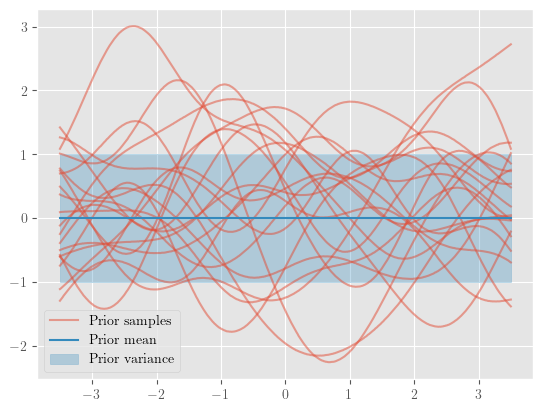

In [10]:
with mpl.style.context("ggplot"):
    fig, ax = plt.subplots()
    ax.plot(xtest, samples.T, alpha=0.5, color=cols[0], label="Prior samples")
    ax.plot(xtest, prior_mean, color=cols[1], label="Prior mean")
    ax.fill_between(
        xtest.flatten(),
        prior_mean - prior_std,
        prior_mean + prior_std,
        alpha=0.3,
        color=cols[1],
        label="Prior variance",
    )
    ax.legend(loc="best")
    ax = clean_legend(ax)
    plt.show()

## Constructing the posterior

In [11]:
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)

In [12]:
posterior = prior * likelihood

## Parameter state

In [13]:
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    # we use the negative mll as we are minimising
    objective=lambda p, d: -gpx.objectives.conjugate_mll(p, d),
    train_data=D,
)

print(-gpx.objectives.conjugate_mll(opt_posterior, D))

Optimization terminated successfully.
         Current function value: 55.469226
         Iterations: 12
         Function evaluations: 19
         Gradient evaluations: 19
55.46922647118369


## Prediction

In [14]:
latent_dist = opt_posterior.predict(xtest, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean
predictive_std = jnp.sqrt(predictive_dist.variance)

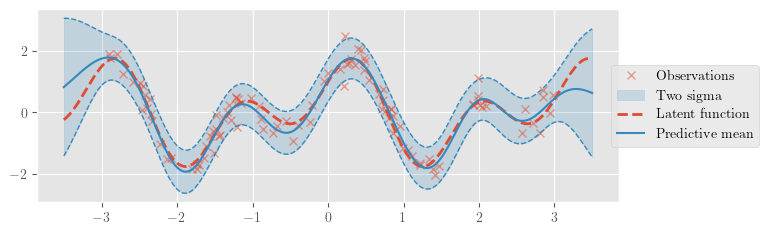

In [15]:
with mpl.style.context("ggplot"):
    fig, ax = plt.subplots(figsize=(7.5, 2.5))
    ax.plot(x, y, "x", label="Observations", color=cols[0], alpha=0.5)
    ax.fill_between(
        xtest.squeeze(),
        predictive_mean - 2 * predictive_std,
        predictive_mean + 2 * predictive_std,
        alpha=0.2,
        label="Two sigma",
        color=cols[1],
    )
    ax.plot(
        xtest,
        predictive_mean - 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax.plot(
        xtest,
        predictive_mean + 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax.plot(
        xtest, ytest, label="Latent function", color=cols[0], linestyle="--", linewidth=2
    )
    ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])
    ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
    plt.show()

# GPyTorch

## Set up training data

In [16]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

## The GP Model

In [17]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

## Training the model

In [18]:
# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.921   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.890   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.856   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.819   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.779   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.735   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.688   lengthscale: 0.438   noise: 0.437
Iter 8/50 - Loss: 0.641   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.597   lengthscale: 0.371   noise: 0.370
Iter 10/50 - Loss: 0.556   lengthscale: 0.341   noise: 0.339
Iter 11/50 - Loss: 0.518   lengthscale: 0.315   noise: 0.311
Iter 12/50 - Loss: 0.484   lengthscale: 0.292   noise: 0.284
Iter 13/50 - Loss: 0.451   lengthscale: 0.274   noise: 0.260
Iter 14/50 - Loss: 0.419   lengthscale: 0.258   noise: 0.237
Iter 15/50 - Loss: 0.387   lengthscale: 0.247   noise: 0.217
Iter 16/50 - Loss: 0.356   lengthscale: 0.238   noise: 0.197
Iter 17/50 - Loss: 0.325   length

## Make predictions with the model

In [19]:
# f_preds = model(test_x)
# y_preds = likelihood(model(test_x))

# f_mean = f_preds.mean
# f_var = f_preds.variance
# f_covar = f_preds.covariance_matrix
# f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

In [20]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

## Plot the model fit

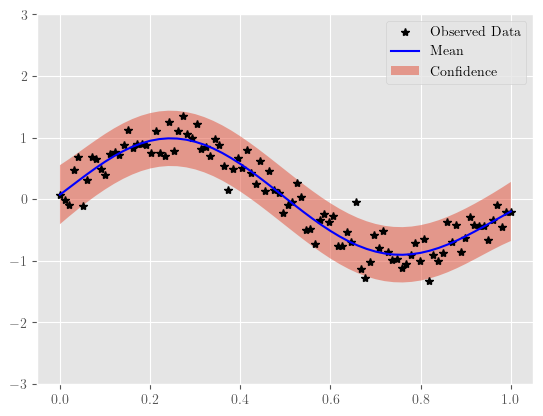

In [21]:
with torch.no_grad():
    with mpl.style.context("ggplot"):
        # Initialize plot
        f, ax = plt.subplots(1, 1)#, figsize=(4, 3))
    
        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        plt.show()

## Long demo data

In [43]:
# path = './PFCS/table task/xyz data/full_tasks/fetch_recorded_demo_1730997119.txt'
path = "./PFCS/table task/xyz data/full_tasks/fetch_recorded_demo_1730997956.txt"
# h5_path = './PFCS/table task/h5 files/fetch_recorded_demo_1730997119.h5'
h5_path = "./PFCS/table task/h5 files/fetch_recorded_demo_1730997956.h5"
data = np.loadtxt(path)  # load the file into an array

# x = data[:, 0]
# y = data[:, 1]
# z = data[:, 2]

joint_data, tf_data, gripper_data = read_data(h5_path)
# time = tf_data[0][:, 0] + tf_data[0][:, 1] * (10.0 ** -9)

# traj_list = [x, y, z]
# traj = data
# traj.shape

In [44]:
# nanosec_conv = 1e-9
time_sec = tf_data[0][:, 0]
time_nanosec = tf_data[0][:, 1]
# time = time_sec + time_nanosec * nanosec_conv

In [45]:
timestamps = []
for t_idx, t_val in enumerate(time_sec):
    timestamp = pd.Timestamp(time_sec[t_idx], unit="s", tz="EST") + pd.to_timedelta(time_nanosec[t_idx], unit="ns")
    timestamps.append(timestamp)

In [46]:
traj = pd.DataFrame(
    {
        "x": data[:, 0],
        "y": data[:, 1],
        "z": data[:, 2],
        "timestamps": timestamps
    }
)
traj

,x,y,z,timestamps
0,0.481500,0.644665,1.017521,2024-11-07 11:45:56.903842926-05:00
1,0.481850,0.644203,1.016694,2024-11-07 11:45:56.933827400-05:00
2,0.482194,0.644541,1.017576,2024-11-07 11:45:56.963809490-05:00
3,0.482085,0.644321,1.017699,2024-11-07 11:45:56.984044552-05:00
4,0.482415,0.644171,1.017081,2024-11-07 11:45:57.013770819-05:00
...,...,...,...,...
9229,0.411919,0.647518,0.988984,2024-11-07 11:49:23.513942242-05:00
9230,0.412296,0.646968,0.988606,2024-11-07 11:49:23.543920040-05:00
9231,0.410926,0.647857,0.988834,2024-11-07 11:49:23.573862076-05:00
9232,0.410531,0.648087,0.989136,2024-11-07 11:49:23.603845358-05:00


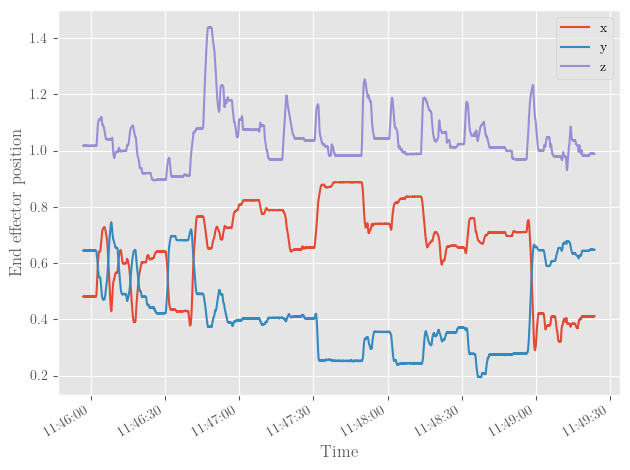

In [47]:
with plt.style.context("ggplot"):
    fig, ax = plt.subplots()
    # cmap = mpl.colormaps.get("tab10").colors
    ax.plot(timestamps, traj.x, label="x")#, color=cmap[0])
    ax.plot(timestamps, traj.y, label="y")#, color=cmap[1])
    ax.plot(timestamps, traj.z, label="z")#, color=cmap[2])
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    ax.legend(loc="best")
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

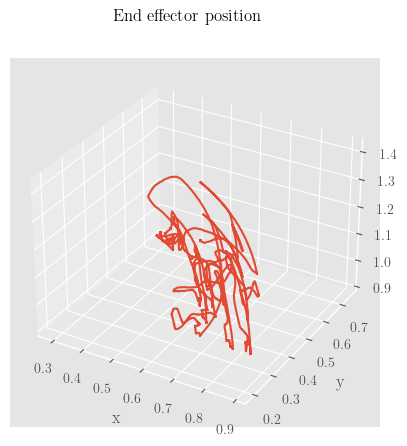

In [48]:
with plt.style.context("ggplot"):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.suptitle('End effector position')
    ax.plot(traj.x, traj.y, traj.z)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()